In [86]:
import os
import shutil
import json
import re
import os
import datetime
from itertools import permutations 
import numpy as np
import time
from matplotlib import pyplot as plt
from google.colab import drive
import imageio
import glob
from PIL import Image
from functools import reduce
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import itertools
import pickle
import random
from sklearn.model_selection import train_test_split
from fastai.layers import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.parsing.preprocessing import remove_stopwords
import nltk
nltk.download('punkt')
# from gensim.models import Word2Vec


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = "./drive/My Drive/cs472/data/data.pkl"
data_path2 = "./drive/My Drive/cs472/data/data2.pkl"

clean_data_path = "./drive/My Drive/cs472/data/clean_data.pkl"
clean_data_path2 = "./drive/My Drive/cs472/data/clean_data2.pkl"

word_dict_path = "./drive/My Drive/cs472/data/word_dict.pkl"
name_dict_path = "./drive/My Drive/cs472/data/name_dict.pkl"

word_encoder_path = "./drive/My Drive/cs472/models/word_encoder.pkl"
name_encoder_path = "./drive/My Drive/cs472/models/name_encoder.pkl"
word_decoder_path = "./drive/My Drive/cs472/models/word_decoder.pkl"
name_decoder_path = "./drive/My Drive/cs472/models/name_decoder.pkl"

regressor_path = "./drive/My Drive/cs472/models/regressor.pkl"
regressor_path2 = "./drive/My Drive/cs472/models/regressor2.pkl"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Preprocess

In [0]:
def preprocess(file_path):

    d = pd.read_pickle(file_path)

    # get names
    d['actor'] = d['actor'].str.lower().values
    d['director'] = d['director'].str.lower().values
    names = list(d['actor'].values) + list(d['director'].values)
    names = list(dict.fromkeys(names))

    max_name_length = len(max(max(d['actor'], key=len), max(d['director'], key=len)))
    print("Max length of names:", max_name_length)

    name_dict = dict(map(reversed, enumerate(names)))
    longest_name = max(names, key=len)
    len_longest_name = len(longest_name)
    name_embedding_length = len_longest_name - (len_longest_name//3)

    name_dict[len(name_dict)] =  "SOS"
    name_dict[len(name_dict)] =  "EOS"

    name_dict['em_length'] = name_embedding_length
    name_dict['max_length'] = max_name_length

    print(name_embedding_length)
    print(len(name_dict))

    # save out dictionary
    f = open(name_dict_path,"wb")
    pickle.dump(name_dict,f)
    f.close()

    # titles and descriptions
    d['title'] = d.title.str.lower()
    d['title'] = d.title.str.replace("-", " ").copy()
    title_tokens = set(itertools.chain(*np.array(d.title.apply(word_tokenize).values)))
        
    d['description'] = d.description.str.replace("-", " ").copy()
    d['description'] = d.description.str.lower().copy()
    d['description'] = d.description.apply(remove_stopwords).copy()
    d['description'] = d.description.str.replace('[^\w\s]','').copy()
    tokens = set(itertools.chain(*np.array(d.description.apply(word_tokenize).values)))

    # save cleaned pickle file
    pd.to_pickle(d, clean_data_path2)

    # get the vocabulary
    s = tokens.union(title_tokens)
    vocab_size = len(s)

    # make a dictionary of all the words and save it out
    word_dict = dict(map(reversed, enumerate(s)))

    # get longest word
    longest_word = max(s, key=len)
    len_longest_word = len(longest_word)
    embedding_length = len_longest_word - (len_longest_word//3)

    max_desc_length = len(max(tokens, key=len))
    print("Max length of descriptions:", max_desc_length)

    word_dict[len(name_dict)] =  "SOS"
    word_dict[len(name_dict)] =  "EOS"

    word_dict['em_length'] = embedding_length
    word_dict['max_length'] = max_desc_length


    # save out dictionary
    f = open(word_dict_path,"wb")
    pickle.dump(word_dict,f)
    f.close()
    
    print("Size of Vocabulary:", vocab_size)
    print("Longest Word:", longest_word, "with length", len_longest_word)


In [0]:
%time preprocess(data_path2)

Max length of names: 30
24
19471
Max length of descriptions: 27
Size of Vocabulary: 34209
Longest Word: romanticpoliticalbiographic with length 27
CPU times: user 6.26 s, sys: 72.2 ms, total: 6.33 s
Wall time: 7.71 s


In [0]:
data = pd.read_pickle(clean_data_path2)
# len(data[data.genre==1])
len(word_tokenize(data.title.max()))

5

# Dataset Loader

In [0]:
class MovieRatings(Dataset):

    def __init__(self, word_encoder, name_encoder, file_path=clean_data_path2, test=False, test_split=.3,classifier=False):
        """
        params:
            genre int: 1-14 corrisponding to just training 
            on a certain genre or not
        """
        super(MovieRatings, self).__init__()

        self.classifier = classifier
        self.test = test

        self.word_embeds, self.word_dict, self.word_embed_len, self.word_max_length  = self._get_embedding(word_dict_path)
        self.name_embeds, self.name_dict, self.name_embed_len, self.name_max_length = self._get_embedding(name_dict_path)

        data = pd.read_pickle(file_path)
        s_rating_dummies = pd.get_dummies(data.s_rating, drop_first=True)
        genre_dummies = pd.get_dummies(data.genre, drop_first=True)

        n = int(len(data)*test_split)

        self.test_data = data.iloc[:n,:]
        self.test_s_rating_dummies = s_rating_dummies.iloc[:n,:]
        self.test_genre_dummies = genre_dummies.iloc[:n,:]

        self.train_data = data.iloc[n:,:]
        self.train_s_rating_dummies = s_rating_dummies.iloc[n:,:]
        self.train_genre_dummies = genre_dummies.iloc[n:,:]

        self.word_encoder = word_encoder 
        self.name_encoder = name_encoder


    def _get_embedding(self,path_):

        # get name embedding space
        dict_ = pickle.load( open(path_, "rb" ) ) 

        # make embedding space for names
        vocab_size = len(dict_) - 2
        
        embed_length = dict_['em_length']
        return nn.Embedding(vocab_size, embed_length), dict_, embed_length, dict_['max_length']

    def __getitem__(self, i):
        if self.test:
            data = self.test_data
            s_rating_dummies = self.test_s_rating_dummies
            genre_dummies = self.test_genre_dummies
        else:
            data = self.train_data
            s_rating_dummies = self.train_s_rating_dummies
            genre_dummies = self.train_genre_dummies

        actor = data.actor.iloc[i].lower()
        director = data.director.iloc[i].lower()

        title_tokens = word_tokenize(data.title.iloc[i].lower())
        text_tokens = word_tokenize(data.description.iloc[i].lower())

        word_idx = torch.tensor([],dtype=torch.long)

        for t in text_tokens + title_tokens:
            idx = torch.tensor([self.word_dict[t]])
            word_idx = torch.cat((word_idx, idx),0)
        
        actor_idx = torch.tensor([self.name_dict[actor]], dtype=torch.long)
        director_idx = torch.tensor([self.name_dict[director]],dtype=torch.long)

        name_idx = torch.cat((actor_idx, director_idx),0)

        run_time = torch.Tensor([data.runtime.iloc[i]]).cuda()
        s_rating = torch.Tensor(s_rating_dummies.iloc[i].values).cuda()
        genre = torch.Tensor(genre_dummies.iloc[i].values).cuda()

        if self.classifier:
            label = float(data.rating_class.iloc[i])
        else:
            label = float(data.rating_label.iloc[i])

        w_encoder_hidden = self.word_encoder.initHidden()
        n_encoder_hidden = self.name_encoder.initHidden()

        # encode description, title and names 
        for e_i in range(len(word_idx)):
            encoder_output, w_encoder_hidden = self.word_encoder(word_idx[e_i].cuda(), w_encoder_hidden)

        for e_i in range(len(name_idx)):
            encoder_output, n_encoder_hidden = self.name_encoder(name_idx[e_i].cuda(), n_encoder_hidden)

        w_encoder_hidden = w_encoder_hidden.squeeze(0).squeeze(0)
        n_encoder_hidden = n_encoder_hidden.squeeze(0).squeeze(0)

        return torch.cat((w_encoder_hidden,n_encoder_hidden, s_rating, run_time, genre), dim=0), label

    def __len__(self):
        if self.test:
            return len(self.test_data)
        else:
            return len(self.train_data)


In [25]:
dataset = MovieRatings()
# len(dataset.data)
dataset[0]
# data_loader = DataLoader(dataset)

TypeError: ignored

# Encoder/ Decoder Netowrks For Text Data

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input_, hidden):
        embedded = self.embedding(input_).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_, hidden):
        output = self.embedding(input_).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Training Encoder/Decoder

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, encoder, decoder, SOS_token, EOS_token,
          encoder_optimizer, decoder_optimizer, 
          criterion, max_length=50):
    
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = input_length
    target_tensor = input_tensor.clone()

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # loop through input to encode
    for e_i in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[e_i], encoder_hidden)
        encoder_outputs[e_i] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    print("target", target_tensor)

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for d_i in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            print("decode output", decoder_output)
            loss += criterion(decoder_output, target_tensor[d_i:d_i+1])
            decoder_input = target_tensor[d_i]

    else:
        # Without teacher forcing: use its own predictions as the next input
        for d_i in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            print("decode output", decoder_output)
            loss += criterion(decoder_output, target_tensor[d_i:d_i+1])
            if decoder_input.item() == EOS_token:
                break


    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
def trainIters(encoder, decoder, data_set, epochs, kind="word", print_every=1000, plot_every=1000, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    data_loader = DataLoader(MovieRatings(), batch_size=1, shuffle=True)

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    SOS_token = len(data_set.word_dict)-4 if kind == "word" else len(data_set.name_dict)-4
    EOS_token = len(data_set.word_dict)-3 if kind == "word" else len(data_set.name_dict)-3
    
    criterion = nn.NLLLoss()
    print("training")

    for e in range(epochs):
        print("epoch",e)
        for i, (word_idx, name_idx, numeric, label) in enumerate(data_loader):
            if kind == "word":
                input_tensor = word_idx.squeeze(0)
            else:
                input_tensor = name_idx.squeeze(0)

            loss = train(input_tensor, encoder, decoder, SOS_token,EOS_token,
                        encoder_optimizer, decoder_optimizer, criterion)       
        
            print_loss_total += loss
            plot_loss_total += loss

            if i % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print(print_loss_avg)

            if i % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

        if kind == "word":
            torch.save(encoder, word_encoder_path)
            torch.save(decoder, word_decoder_path)
        else:
            torch.save(encoder, name_encoder_path)
            torch.save(encoder, name_decoder_path)

    return encoder

In [0]:
def main(kind="word"):

    dataset = MovieRatings()

    if kind == "word":
        vocab_size = len(dataset.word_dict)
        embed_size = dataset.word_embed_len

        if os.path.exists(word_encoder_path):
            encoder = torch.load(word_encoder_path)
            decoder = torch.load(word_decoder_path)

            print("loaded")
        else:
            encoder = EncoderRNN(vocab_size,embed_size).to(device)
            decoder = DecoderRNN(embed_size, vocab_size).to(device)


    elif kind == "name":
        vocab_size = len(dataset.name_dict)
        embed_size = dataset.name_embed_len

        if os.path.exists(name_encoder_path):
            encoder = torch.load(name_encoder_path)
            decoder = DecoderRNN(embed_size, vocab_size).to(device)
            torch.save(encoder, name_decoder_path)
            decoder = torch.load(name_decoder_path)
        else:
            encoder = EncoderRNN(vocab_size,embed_size).to(device)
            decoder = DecoderRNN(embed_size, vocab_size).to(device)

    encoder = trainIters(encoder, decoder, dataset, 20, kind=kind)
    

In [0]:
main()

loaded
training
epoch 0
0.011638392130533854
10.373293525701
9.635096962202237
9.33704219610897
9.155613743206626
9.067165618168616
9.003137619822688
8.91562369269399
8.885386338250507
8.898630150996302
8.843544294167538
8.830918420940758
8.80016822998259
8.752269705635646
8.75423780210036
8.744448358876495
8.750338638753915
8.69160266990502
8.712438485496165
8.749938103240646
8.683691126148828
8.72991367904921
8.696759021358348
8.687068909202722
8.68275417005081
8.642807207172668
8.659069039481912
8.631738657001295


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch 1
0.5466761194003443
8.603201221325639
8.630741364553426
8.612298289006374
8.626766278613335
8.596503582112225
8.604612368337008
8.619568051557232
8.582622720719337
8.599156915624413
8.608003263888124
8.627156635675195
8.597055373085029
8.619668791375942
8.570115033335178
8.625201493831335
8.602384558451329
8.574679501888825
8.590454130227817
8.558109694075577
8.59649586463335
8.53896045147026
8.570470656359175
8.56527411858523
8.574539609221478
8.562724701879112
8.566540567480978
8.56741044898803
epoch 2
0.5482652906212904
8.502424294157839
8.52661898396534
8.538345995428326
8.499856123571755
8.517296507530132
8.494928444816324
8.469397302003276
8.504019129983115
8.536309990973269
8.49248158728073
8.449360893000698
8.47493880804904
8.512396106619912
8.49282759631716
8.458258771325074
8.456735762711354
8.466036373620927
8.475839800901067
8.453195493395457
8.45532513921198
8.51905865078503
8.50744433186379
8.471606060112968
8.483179283040236
8.482717937972259
8.441590240899819
8.4

In [0]:
main(kind="name")

In [0]:
def eval(encoder, decoder, input_tensor, dict_, inv_dict, max_length=50):

    for word in input_tensor:
        print(inv_dict[word])

    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            decoded_words.append(decoder_output)

    for word in decoded_words:
        print(inv_dict[word])

    return decoded_words, decoder_attentions[:di + 1]

In [0]:
def evaluate(n=1):

    encoder = torch.load(word_encoder_path)
    decoder = torch.load(word_decoder_path)
    data_loader = DataLoader(MovieRatings(), batch_size=1, shuffle=True)

    dict_ = pickle.load( open(word_dict_path, "rb" ) ) 
    inv_dict = dict(map(reversed, dict_.items()))

    for i in range(n):
        eval(encoder, decoder, data_loader[i], dict_, inv_dict)

# Regression Neural Net

In [0]:
class RegressionNet(nn.Module):

    def __init__(self, in_dim=64):
        super(RegressionNet, self).__init__()

        # another way to define a network
        self.net = torch.nn.Sequential(
                        torch.nn.Linear(in_dim, 100),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(100, 200),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(200, 100),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(100, 50),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(50, 1))

    def forward(self, x):
        return self.net(x)

In [0]:
def train_regress(epochs=20, print_every=10, r_path=regressor_path):

    word_encoder = torch.load(word_encoder_path).cuda()
    name_encoder = torch.load(name_encoder_path).cuda()
    regressor = torch.load(r_path).cuda()

    data_set = MovieRatings(word_encoder,name_encoder)
    data_loader = DataLoader(data_set, batch_size=64, shuffle=True)
    n = len(data_loader)

    optimizer = torch.optim.Adam(itertools.chain(word_encoder.parameters(),
                                                 name_encoder.parameters(),
                                                 regressor.parameters()), lr=0.01)
    loss_func = MSELossFlat() #torch.nn.MSELoss()
    

    losses = []
    for e in range(1,epochs+1):
        print("Epoch", e)
        epoch_loss = 0
        print_loss_total = 0

        for i, (x, label) in enumerate(data_loader):
            
            # run regression and get loss
            pred_y = regressor(x.cuda())

            loss = loss_func(pred_y, label.long().cuda())

            epoch_loss += loss.item()
            losses.append(loss.item())

            if i % print_every == 0:
                print("Step", i, ":", np.mean(losses[-10:]))
                
                torch.save(regressor, r_path)
                torch.save(word_encoder, word_encoder_path)
                torch.save(name_encoder, name_encoder_path)

            optimizer.zero_grad()   
            loss.backward()#retain_graph=True
            optimizer.step()

        print("Average Epoch Loss:", epoch_loss/n)

    return data_set, regressor

In [70]:
torch.save(RegressionNet(), regressor_path2)
dataset, regressor = train_regress(r_path=regressor_path2)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RegressionNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1
Step 0 : 29.97827911376953


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RegressionNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Step 10 : 23.63948760032654
Step 20 : 3.7310128688812254
Step 30 : 3.5388919830322267
Step 40 : 3.538793110847473
Step 50 : 2.7908554077148438
Step 60 : 2.5297589182853697
Step 70 : 2.3980841398239137
Step 80 : 2.4206475734710695
Step 90 : 2.2256847381591798
Step 100 : 1.8266412615776062
Step 110 : 1.8226126432418823
Step 120 : 1.5747804522514344
Step 130 : 1.7296615242958069
Step 140 : 1.8519200921058654
Step 150 : 1.6441534876823425
Step 160 : 1.5568920850753785
Step 170 : 1.9605435609817505
Step 180 : 1.5984519720077515
Step 190 : 1.6057345032691956
Step 200 : 1.6863449811935425
Step 210 : 1.6038021206855775
Step 220 : 1.6635065078735352
Step 230 : 1.8346874356269836
Step 240 : 1.7405985355377198
Step 250 : 1.9457938551902771
Step 260 : 1.9671810150146485
Step 270 : 1.8160136222839356
Step 280 : 1.6802731275558471
Step 290 : 1.6670244097709657
Average Epoch Loss: 2.8833399986979935
Epoch 2
Step 0 : 1.6649189829826354
Step 10 : 1.9788997769355774
Step 20 : 2.287485146522522
Step 30 :

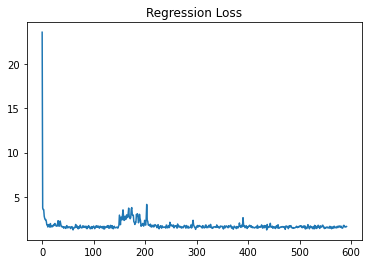

In [77]:
a = [23.63948760032654,3.7310128688812254,3.5388919830322267,3.538793110847473,2.7908554077148438,2.5297589182853697,2.3980841398239137,2.4206475734710695,2.2256847381591798,1.8266412615776062,1.8226126432418823,1.5747804522514344,1.7296615242958069,1.8519200921058654,1.6441534876823425,1.5568920850753785,1.9605435609817505,1.5984519720077515,1.6057345032691956,1.6863449811935425,1.6038021206855775,1.6635065078735352,1.8346874356269836,1.7405985355377198,1.9457938551902771,1.9671810150146485,1.8160136222839356,1.6802731275558471,1.6670244097709657,1.6649189829826354,1.9788997769355774,2.287485146522522,1.7207539796829223,1.652290689945221,1.8845996379852294,2.249750077724457,1.9487884759902954,1.6277625560760498,1.6056967735290528,1.6372004985809325,1.5774993181228638,1.5866549611091614,1.4299665451049806,1.5778466820716859,1.5760279297828674,1.5161873698234558,1.4124821543693542,1.6462961554527282,1.7293179988861085,1.509164822101593,1.4679332613945006,1.5912979245185852,1.567425000667572,1.5821929752826691,1.5926974654197692,1.3974286437034606,1.5099110722541809,1.5787468671798706,1.6186208963394164,1.3620702657848596,1.2463204741477967,1.4407684445381164,1.5221697807312011,1.4963760495185852,1.509787654876709,1.8561355948448182,1.7647417783737183,1.5217341184616089,1.6890993595123291,1.4868379592895509,1.3642069697380066,1.5997826218605042,1.4386527061462402,1.4967490315437317,1.7840389609336853,1.527709698677063,1.5122908353805542,1.460020363330841,1.5327269554138183,1.7089971363544465,1.529446816444397,1.6548919558525086,1.5933759450912475,1.6371606111526489,1.4974799513816834,1.6630700469017028,1.6147354543209076,1.375999289751053,1.5929417848587035,1.504815047979355,1.7267858862876893,1.5673058032989502,1.626545000076294,1.3785046219825745,1.3876992523670197,1.4210498332977295,1.6211077332496644,1.3902597665786742,1.611822748184204,1.5364004373550415,1.6773049354553222,1.5308062791824342,1.3861291885375977,1.5128313899040222,1.5571601510047912,1.720938467979431,1.5696717262268067,1.5522677779197693,1.6919808864593506,1.540165913105011,1.6423703789711,1.4338365137577056,1.6110373616218567,1.6666245341300965,1.595628809928894,1.4882213652133942,1.6022398114204406,1.626602792739868,1.443321907520294,1.374821405520197,1.6518424153327942,1.349837863445282,1.528708815574646,1.591989815235138,1.5234298825263977,1.5604309558868408,1.686996829509735,1.5526540875434875,1.7323722839355469,1.456289291381836,1.4458529949188232,1.6670520186424256,1.4820118427276612,1.7638343095779419,1.5394953846931458,1.4708619594573975,1.7182538986206055,1.5155243098735809,1.3711166501045227,1.5004495322704314,1.6547746062278748,1.4915873885154725,1.4776412010192872,1.4976331114768981,1.5526248574256898,1.5113723039627076,1.5231546759605408,1.4457776546478271,1.6298669815063476,1.7355843782424927,2.919375705718994,2.3694878697395323,1.8352251648902893,2.6956708312034605,2.655014765262604,2.379216170310974,2.915577471256256,3.512195897102356,2.7202182054519652,2.321783256530762,2.4433849096298217,2.7967835903167724,2.419164609909058,2.52241907119751,2.946675157546997,2.7046121835708616,2.6445175647735595,3.0925604581832884,3.7130346059799195,2.766263222694397,2.6533337354660036,2.5109963536262514,2.667663311958313,3.6165145874023437,3.7686266183853148,2.953689897060394,2.887112045288086,2.9175302267074583,2.1590128540992737,2.102255177497864,1.8610278487205505,2.0883387327194214,2.0658130764961244,3.0008469104766844,2.824829030036926,3.0706108927726747,2.700793731212616,2.04626704454422,2.282307356595993,3.0106335997581484,2.551390993595123,2.2870928049087524,1.6550434589385987,1.7686383128166199,1.7955866813659669,1.9724652290344238,1.8153830647468567,1.6705814003944397,1.8769320964813232,2.32726628780365,1.8890939354896545,1.783400058746338,2.5101970434188843,4.130855226516724,2.3215047478675843,2.2333560824394225,1.8047037720680237,1.7877434372901917,1.819242489337921,1.6798553049564362,1.8983316898345948,1.6372491836547851,1.5657285928726197,1.7824323177337646,1.7220169067382813,1.6010552763938903,1.769887101650238,1.5856457829475403,1.7303412675857544,1.838882577419281,1.7271790385246277,1.7522998929023743,1.6796557545661925,1.4936877369880677,1.5807045698165894,1.8380472302436828,1.6671354293823242,1.3688917279243469,1.5277010440826415,1.590848183631897,1.7210683941841125,1.5882745146751405,1.4373624175786972,1.6989512205123902,1.60247243642807,1.5623340129852294,1.5208447217941283,1.5443803071975708,1.5816893100738525,1.5711776733398437,1.4454649567604065,1.789099383354187,1.7764584302902222,1.4897143483161925,1.4854795157909393,1.5322001338005067,1.7311649918556213,1.5093348801136017,2.106648087501526,1.8912765026092528,1.703181529045105,1.7695202350616455,1.7854139447212218,1.6352163910865785,1.6492251396179198,1.798626220226288,1.4799168705940247,1.5728116393089295,1.6875527322292327,1.708535385131836,1.6227306067943572,1.7078002452850343,1.4410066939890385,1.910949945449829,1.6095294594764709,1.5855515718460083,1.6887520551681519,1.6368744015693664,1.520090651512146,1.635040295124054,1.5030403971672057,1.448222541809082,1.5849572777748109,1.555473017692566,1.4871482610702516,1.6298844695091248,1.7599026679992675,1.6785809516906738,1.6104175090789794,1.442113184928894,1.741139256954193,1.5580462217330933,1.4894386649131774,1.6667961120605468,1.4518734693527222,1.4925562739372253,1.5075868487358093,1.5116301774978638,1.6438276410102843,1.8112398862838746,1.4602665305137634,1.5610406875610352,1.9577155232429504,2.332210457324982,1.8155151724815368,1.6752721548080445,1.5336487770080567,1.4800007820129395,1.3039790272712708,1.5628435492515564,1.6641686677932739,1.559764325618744,1.7420625925064086,1.5790706992149353,1.6785444617271423,1.7483733654022218,1.653809404373169,1.6358391046524048,1.6674647092819215,1.588201093673706,1.4968189954757691,1.457471239566803,1.7276102304458618,1.518505072593689,1.5403757691383362,1.4711898684501648,1.5182250380516051,1.772458589076996,1.8027240872383117,1.4997762322425843,1.629825234413147,1.5071747720241546,1.5109777241945266,1.6794643640518188,1.769541597366333,1.6704235315322875,1.5313626885414124,1.867364728450775,1.540811550617218,1.4718947052955627,1.5404232919216156,1.4204624056816102,1.5532785415649415,1.5206844806671143,1.5877590298652648,1.6004639506340026,1.5943050622940063,1.5294932961463927,1.5288246989250183,1.8098283767700196,1.5419310808181763,1.6439143419265747,1.511615478992462,1.5536516427993774,1.4448819696903228,1.5314794063568116,1.6765119075775146,1.6097695708274842,1.6509467840194703,1.6371580123901368,1.6437106132507324,1.4405755043029784,1.3513026719912886,1.5193669557571412,1.701940941810608,1.4703899502754212,1.647447657585144,1.5956378340721131,1.695990550518036,1.6053018927574159,1.5674063324928285,1.4828567028045654,1.7210804224014282,1.5734774947166443,1.6095953583717346,1.6738265872001648,1.7802303314208985,1.5621147990226745,1.4357065260410309,1.5963311791419983,1.4942855000495912,1.3178970873355866,1.4918853878974914,1.6656980752944945,1.583921843767166,1.557656168937683,1.5490182518959046,1.393448293209076,1.632590401172638,1.5701551556587219,1.4542673230171204,1.5858848094940186,1.6110663294792176,2.029900074005127,1.6341030597686768,1.7116285681724548,1.52802734375,1.7661845803260803,1.7582432806491852,1.613861095905304,2.6252963066101076,1.8690042972564698,1.6462525248527526,1.6619152665138244,1.4912832260131836,1.5428643107414246,1.7238707423210144,1.6416891515254974,1.4042570531368255,1.556576907634735,1.5441873788833618,1.673016905784607,1.6944741785526276,1.773996925354004,1.6226737260818482,1.568685245513916,1.7129312992095946,1.592448341846466,1.487179982662201,1.580471432209015,1.5090933680534362,1.5185762643814087,1.4664432287216187,1.4745781302452088,1.5633864402770996,1.5329750299453735,1.5801754236221313,1.449437403678894,1.7623650550842285,1.4559414327144622,1.494618785381317,1.5653082370758056,1.6120825409889221,1.565162682533264,1.6280452370643617,1.5763778924942016,1.8067891120910644,1.702987587451935,1.445455551147461,1.6017412662506103,1.6913232684135437,1.4778803706169128,1.7343668580055236,1.6635727524757384,1.5750520467758178,1.7214659571647644,1.2415863394737243,1.8610112905502318,1.4692039370536805,1.5702249884605408,1.5706088542938232,1.5539504289627075,1.6446591854095458,1.989194965362549,1.5749765872955321,1.5723470211029054,1.5401247143745422,1.6623470067977906,1.4259334921836853,1.587083888053894,1.5746344923973083,1.4904719471931458,1.565251874923706,1.4016470789909363,1.576850128173828,1.7247864246368407,1.699311649799347,1.4765097498893738,1.8263611197471619,1.440930712223053,1.4371585965156555,1.4646069645881652,1.5540979743003844,1.574343776702881,1.5318508267402648,1.5840554237365723,1.6140058994293214,1.6156505227088929,1.5270668864250183,1.6149725794792176,1.6106476783752441,1.4858495235443114,1.3070891100913287,1.6694341540336608,1.6016186952590943,1.6684072136878967,1.6118425607681275,1.5083310842514037,1.387621569633484,1.6587429881095885,1.7206423997879028,1.5607022285461425,1.682567286491394,1.7296265065670013,1.548151171207428,1.4748667359352112,1.4656371235847474,1.5185107350349427,1.4266735434532165,1.4756725788116456,1.4608765900135041,1.4904906451702118,1.5190446376800537,1.587452471256256,1.6586888909339905,1.5296169638633728,1.5087408423423767,1.5758469343185424,1.6265758752822876,1.5729270219802856,1.6764259219169617,1.7051709175109864,1.6174106001853943,1.7072444200515746,1.5410966873168945,1.4900797367095948,1.5708524227142333,1.6884498119354248,1.5228485226631165,1.5772797226905824,1.7064518094062806,1.3511943817138672,1.5765440344810486,1.4222636342048645,1.3992845058441161,1.5577992796897888,1.8395412683486938,1.678876781463623,1.551486474275589,1.3681900560855866,1.6098644852638244,1.6897025465965272,1.5616437196731567,1.5764028191566468,1.4780429124832153,1.3934617936611176,1.6050016045570374,1.5366955161094666,1.352200174331665,1.7575416803359984,1.581957221031189,1.6886209845542908,1.3960083051584662,1.5891530394554139,1.4641343235969544,1.505738127231598,1.770171332359314,1.5698045253753663,1.563934600353241,1.4116131663322449,1.7096125841140748,1.6059900522232056,1.558618974685669,1.5699745535850524,1.761509907245636,1.7705307602882385,1.6366098642349243,1.4954817295074463,1.3996288776397705,1.542446458339691,1.435717523097992,1.4576398015022278,1.543528687953949,1.5789530396461486,1.54669508934021,1.452308475971222,1.4930216431617738,1.4823060989379884,1.6397753834724427,1.4377641558647156,1.6285335183143617,1.5883503556251526,1.3761426270008088,1.4793243885040284,1.5778740286827087,1.4313708305358888,1.5734127461910248,1.6623722672462464,1.4800383925437928,1.5626100301742554,1.5257899165153503,1.4678353309631347,1.5294471263885498,1.6511679410934448,1.5036559462547303,1.5841994643211366,1.6755050659179687,1.6875625729560852,1.5603934526443481,1.5806886434555054,1.6824631214141845,1.4996302247047424,1.5015559196472168,1.4356574892997742,1.5068900346755982,1.7364009976387025,1.7566551566123962,1.6989286541938782,1.561800765991211,1.5847935676574707,1.584889578819275,1.6252023577690125]
plt.plot(a)
plt.title("Regression Loss")
plt.show()

In [0]:
 def score_regression():

    word_encoder = torch.load(word_encoder_path).cuda().eval()
    name_encoder = torch.load(name_encoder_path).cuda().eval()
    regressor = torch.load(regressor_path2).cuda().eval()

    data_set = MovieRatings(word_encoder,name_encoder)
    data_loader = DataLoader(data_set, batch_size=1, shuffle=True)
    n = len(data_loader)

    labels = []
    guesses = []
    mse = 0
    for i, (x, label) in enumerate(data_loader):

        pred_y = regressor(x.cuda()).detach().cpu()
        guesses.append(pred_y.detach().cpu().item())
        labels.append(label.item())


    MSE = mean_squared_error(labels,guesses)
    RMSE = mean_squared_error(labels,guesses,squared=False)
    R2 = r2_score(labels,guesses)

    print("RSME", RMSE)
    print("R2", R2)
    print("MSE:", MSE)

In [91]:
score_regression()

RSME 1.2603989134936178
R2 0.06572310246303348
MSE: 1.588605421135892
